This is a Jupyter Notebook. It is a really neat way of combining code together with documentation as well as results. As if that wasn't enough, you're also able to run the code yourself, without installing anything, by navigating to the link below. 

http://mybinder.org/repo/selimb/schoolstuff/mech546/

You can then navigate into the desired assignment directory and open up the notebook. You can make modifications if you wish -- they're merely local. 

Jupyter Notebooks are a mix between Mathematica/Maple and the MATLAB command window, meaning you can execute single cells at a time -- as opposed to the whole code -- and the order in which they *appear* does not matter, but the order in which they are *executed* does. You can run cells by clicking on one with your cursor and pressing `Ctrl+Enter`. Alternatively, pressing `Shift+Enter` will run the cell and then select the one beneath it.

In [1]:
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi as PI
import tabulate
%matplotlib inline

# Problem 1
### Governing Equation
The equation of motion is:
\begin{equation*}
\ddot{\theta} = -\frac{g}{l}\sin(\theta)
\end{equation*}
which is a *second-order* ODE. Thus, it needs to be transformed into a set of *first-order* ODEs. 

### Small-Angle Solution
An approximate solution can be found analytically by linearizing the governing equation using the small-angle approximation: $\sin(\theta) \approx \theta$. The equation then becomes:
\begin{equation*}
\ddot{\theta} = -\frac{g}{l}\theta
\end{equation*}
and its solution $\theta_s(t)$ can be found to be:
\begin{equation*}
\theta_s(t) = \dot{\theta}_0\sqrt{\frac{l}{g}}\sin\left(\sqrt{\frac{g}{l}}t\right) 
+ \theta_0\cos\left(\sqrt{\frac{g}{l}}t\right)
\end{equation*}

### Transformation to First-Order
We use the following change of variables:
\begin{align*}
x_1 &= \theta\\
x_2 &= \dot{\theta}
\end{align*}
which results in the following system of first-order ODEs:
\begin{align*}
\dot{x}_1 &= x_2\\
\dot{x}_2 &= -\frac{g}{l}\sin(x_1)
\end{align*}

### Solving Technique
The problem above is an IVP (Initial Value Problem). Consequently, initial values both for $x_1$ and $x_2$ are needed. Once those have been given, we can solve the problem by initializing a state vector and marching in time with either of the required numerical integration methods.

In [2]:
# Define the pendulum properties and its first-order ODEs
G = 32.2
L = 2.0
def pendulum(x, t):
    """First-order ODE describing pendulum.
    
    Parameters
    ----------
    x : array
        State at time 't'. 
        First and second entries are the displacement and velocity, 
            respectively.
    t : float
    
    Returns
    -------
    dx/dt : array, shape(x0)
    
    """
    return np.array([
        x[1], 
        -(G/L)*np.sin(x[0])
    ])

In [3]:
# Necessary functions
def euler_explicit(func, x, t, dt):
    """
    Perform one step of the explicit Euler method.
    
    Returns
    -------
    xn : array 
        State at next time.
    """
    return x + dt*func(x, t)
    
def rk4(func, x, t, dt):
    """
    Perform one step of the 4th order Runge-Kutta method.
    
    Return value same as `euler_explicit`.
    """
    k1 = func(x, t)
    k2 = func(x + 0.5*dt*k1, t + 0.5*dt)
    k3 = func(x + 0.5*dt*k2, t + 0.5*dt)
    k4 = func(x + dt*k3, t + dt)
    return x + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

def integrate(func, x0, dt, tf):
    """
    Integrate a system of ordinary differential equations.
    
    Solves the system of initial value problems:
        dx/dt = func(x,t)
    
    Parameters
    ----------
    func : callable(x, t)
        Computes the derivative of x.
    x0 : array 
        Initial state.
    dt : float 
        Timestep size.
    tf : float
        Final time.
        
    Returns
    -------
    t : array
        Complete sequence of time points.
    x : array, shape(len(t), len(x0))
        Values of x for each time `t`, with the initial value
        `x0` in the first row.
    """
    time = np.arange(0, tf + dt, dt)
    x = np.empty( (len(time), len(x0)) )
    x[0] = x0
    for i in range(len(time) - 1):
        x[i+1] = rk4(func, x[i], time[i], dt)
    return time, x

def exact(x0, tf):
    """
    Compute the exact trajectory of the linearized equation.
    
    See `integrate` for parameters and return values.
    """
    k = np.sqrt(G/L)
    time = np.linspace(0, tf, 500)
    x = np.empty( (len(time), len(x0)) )
    x[0] = x0
    for i in range(1, len(time)):
        kt = k*time[i]
        x[i] = x0[0]*np.cos(kt)# + x0[1]/k*np.sin(kt) 
    return time, x

In [4]:
# Initial Conditions
theta0 = 0.25*PI
thetadot0 = 0
x0 = np.array([theta0, thetadot0])

In [5]:
# Define cases
H = [0.4, 0.05]
labels = ['$\Delta t = %.2f$' % h for h in H]
styles = ['b-o', 'g-o'] 
tf = 8.0

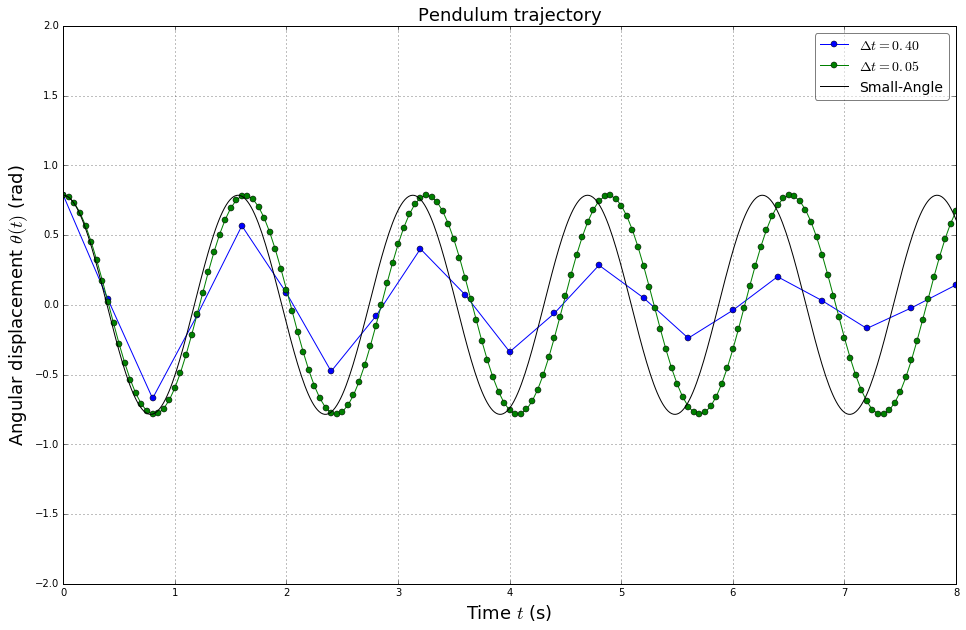

In [6]:
fig, ax = plt.subplots(figsize=(16, 10))
for h, label, style in zip(H, labels, styles):
    t, x = integrate(pendulum, x0, h, tf)
    ax.plot(t, x[:, 0], style, label=label, )
t, x = exact(x0, tf)
ax.plot(t, x[:, 0], 'k-', label='Small-Angle')
ax.set_xlabel('Time $t$ (s)', fontsize=18)
ax.set_ylabel('Angular displacement $\\theta(t)$ (rad)', fontsize=18)
ax.set_ylim(-2, 2)
ax.set_xlim(0, 8)
ax.set_title('Pendulum trajectory', fontsize=18)
ax.grid()
ax.legend(numpoints=1, fancybox=True, framealpha=0.5, loc='best', fontsize=14)
plt.show()

### Explaining Discrepancy
The discrepancy in the RK4 solution with a refined time step and the analytical solution can be attributed to the small-angle approximation used for deriving the latter. Let's find out how accurate that assumption is for the initial angle in this case:
\begin{align*}
\pi/4 &\approx 0.7854\\
\sin(\pi/4) &\approx 0.707\\
\frac{\sin(\pi/4) - \pi/4}{\sin(\pi/4)} &\approx 11\%
\end{align*}

## Going Further
It is clear from the above that both the analytical and computed solution have constant and equal amplitudes but slightly different periods. It might be interesting to look at the effect of the amplitude $\theta_0$ on the period! Let's do that. 

### Analytical solution
The period $T_s$ for the small-angle solution $\theta_s(t)$ derived above only depends on $g$ and $l$ such that:
$$
T_s = 2\pi\sqrt{\frac{l}{g}}
$$

### Zero-crossings method
We're going to use the *zero-crossings method* because it is the easiest. Essentially, we seek the times $t_z$, where $\theta(t_z) = 0$. The way that it is done here is as follows:

1. Find $\theta_i$, $\theta_{i+1}$ such that $\theta_i\cdot\theta_{i+1} < 0$, which comes down to finding when $\text{sign}(\theta_i) \neq \text{sign}(\theta_{i+1})$.
1. Linearly interpolate to find $t_z$
$$
t_z = t_i + \frac{t_{i+1} - t_i}{\theta_{i+1} - \theta_i}(0 - \theta_i)
$$
1. Rinse and repeat.

We can then calculate multiple periods as per the equation below and take an average. 
$$
T^{(i)} = 2\cdot\left(t_z^{(i+1)} - t_z^{(i)}\right)
$$

Of course, this method is dependent on the accuracy of the inputs.

In [7]:
def interp(x, x0, x1, y0, y1):
    """General-purpose 1-D linear interpolation function."""
    dy = y1 - y0
    dx = x1 - x0
    q = dy/dx
    return y0 + q*(x0 - x)

def find_period(t, x):
    """
    Estimate period using zero-crossings method.
    
    Parameters
    ----------
    t : array
    x : array, shape(t)
        Displacement.
    
    Returns
    -------
    T : float
        Estimated period.
    """
    # Find indices right before a zero-cross
    cross_idx = (x[:-1]*x[1:] < 0).nonzero()[0]
    cross_times = []
    for i in cross_idx:
        cross_times.append(interp(0, x[i], x[i+1], t[i], t[i+1]))
    cross_times = np.array(cross_times)
    periods = (cross_times[1:] - cross_times[:-1])*2
    T = np.average(periods)
    return T

Let's do a simple test to make sure the function works: we should find
that *find_period*($t$, $\sin(t$)) = $2\pi$.

In [8]:
t = np.linspace(0, 20, 5000)
T = find_period(t, np.sin(t))
print('Period/Pi = %.3f' % (T/PI))

Period/Pi = 2.000


Excellent! Now let's put this to work.

In [9]:
h = 0.005  # Make sure the computed solution is accurate by reducing h
tf = 5*PI
all_theta0 = np.linspace(0.001*PI, 0.99*PI, 200)
all_T = np.empty_like(all_theta0)
for i in range(len(all_theta0)):
    theta0 = all_theta0[i]
    x0 = np.array([theta0, thetadot0])
    t, x = integrate(pendulum, x0, h, tf)
    all_T[i] = find_period(t, x[:, 0])

Ts = 2*PI*np.sqrt(L/G)

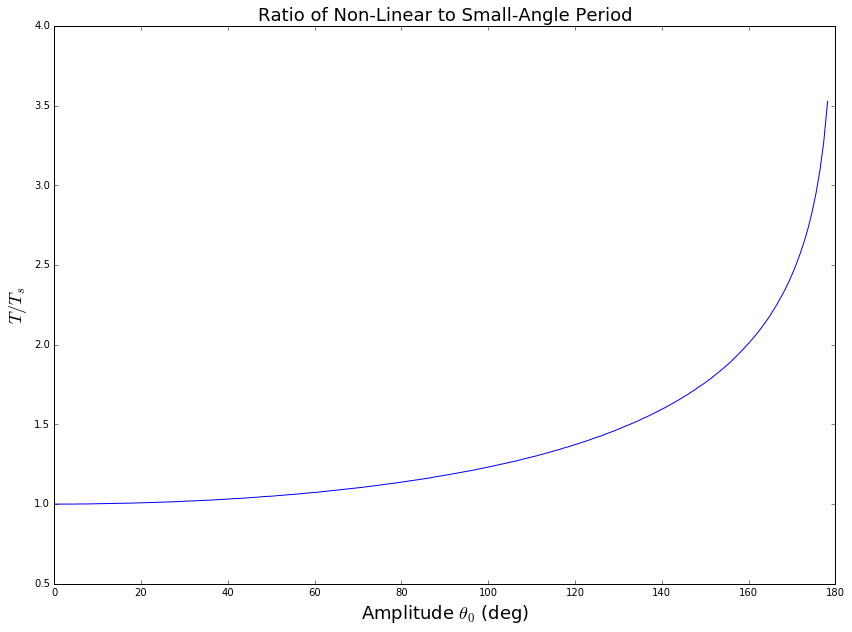

In [10]:
fig, ax = plt.subplots(figsize=(14, 10))
T_ratio = all_T/Ts
ampl = all_theta0/PI*180
ax.plot(ampl, T_ratio)
ax.set_xlabel('Amplitude $\\theta_0$ (deg)', fontsize=18)
ax.set_ylabel('$T/T_s$', fontsize=18)
ax.set_title('Ratio of Non-Linear to Small-Angle Period', fontsize=18)
plt.show()

Let's now look at the extent to which a small-angle approximation is valid, given a tolerance. In other words,

> *What is the maximum amplitude I can consider while still get away with using a small-angle approximation if I want my error to be smaller than a given percentage?*

In [11]:
def find_idx_below(val, arr):
    return (arr >= val).argmax()

errs = 100*(T_ratio - 1) # In percentage
tolerances = [0.1, 0.5, 1, 2, 5, 10]  
max_ampl = []
for tol in tolerances:
    i = find_idx_below(tol, errs)
    max_ampl.append(
        '%.2f' % interp(tol, errs[i], errs[i+1], ampl[i], ampl[i+1])
    )

In [12]:
table = np.vstack((tolerances, max_ampl)).T
headers = ['Error Tolerance (%)', 'Max Amplitude (deg)']
print(tabulate.tabulate(table, headers=headers, tablefmt='grid'))

+-----------------------+-----------------------+
|   Error Tolerance (%) |   Max Amplitude (deg) |
+=======================+=======================+
|                   0.1 |                  8.81 |
+-----------------------+-----------------------+
|                   0.5 |                 21.18 |
+-----------------------+-----------------------+
|                   1   |                 23.53 |
+-----------------------+-----------------------+
|                   2   |                 32.68 |
+-----------------------+-----------------------+
|                   5   |                 52.45 |
+-----------------------+-----------------------+
|                  10   |                 70.4  |
+-----------------------+-----------------------+
